In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

In [28]:
partial_sudokus = pd.read_csv('./partial_sudokus.csv')
partial_sudokus

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0,8,3,2,3,5,4,1,7,0,...,3,0,0,0,0,1,0,0,0,8
1,1,0,0,7,5,4,0,3,2,0,...,4,4,0,3,6,2,8,1,8,0
2,3,0,0,0,5,0,8,3,9,8,...,2,5,8,6,0,0,0,0,0,7
3,0,0,0,0,9,3,0,0,7,8,...,4,4,0,0,2,1,8,0,5,6
4,6,8,0,7,3,0,0,9,0,8,...,0,7,4,0,8,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,8,9,6,0,0,0,5,7,6,...,0,8,6,0,3,0,0,7,1,5
49996,7,4,1,3,0,9,0,0,8,0,...,9,4,9,0,0,0,5,0,1,0
49997,2,0,0,4,8,3,9,1,0,1,...,0,0,0,6,5,0,2,0,5,4
49998,9,0,8,2,0,0,0,0,0,0,...,2,0,9,0,1,7,0,0,0,0


In [76]:
import pandas as pd

def sudoku_edges_dict(df):
    edges_dict = {}

    for a in range(81):
        #flattened_grid = row.values

        # Iterate over each cell in the Sudoku grid
        for i in range(81):
            row, col = divmod(i, 9)

            src_id = i
            dst_ids = set()  # Use a set to store unique values

            # Add dst_ids within the same row for the src_id
            for j in range(9):
                if j != col:
                    dst_ids.add(row * 9 + j)

            # Add dst_ids within the same column for the src_id
            for j in range(9):
                if j != row:
                    dst_ids.add(j * 9 + col)

            # Add dst_ids within the same 3x3 block for the src_id
            block_row, block_col = row // 3, col // 3
            for j in range(3):
                for k in range(3):
                    if i != (block_row * 3 + j) * 9 + (block_col * 3 + k):
                        dst_ids.add((block_row * 3 + j) * 9 + (block_col * 3 + k))

            # Update the dictionary with src_id and its corresponding dst_ids
            edges_dict[src_id] = list(dst_ids)

    return edges_dict


edges_dict = sudoku_edges_dict(partial_sudokus.iloc[0:2])
print("Edges Dictionary:")
for src_id, dst_ids in edges_dict.items():
    print(f"Node {src_id}: {dst_ids}")

# src_ids, dst_ids = sudoku_edges(partial_sudokus.iloc[0:1])
# print("src_ids:", src_ids)
# print("dst_ids:", dst_ids)

print(edges_dict)

Edges Dictionary:
Node 0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 20, 27, 36, 45, 54, 63, 72]
Node 1: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 20, 28, 37, 46, 55, 64, 73]
Node 2: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 20, 29, 38, 47, 56, 65, 74]
Node 3: [0, 1, 2, 4, 5, 6, 7, 8, 12, 13, 14, 21, 22, 23, 30, 39, 48, 57, 66, 75]
Node 4: [0, 1, 2, 3, 5, 6, 7, 8, 12, 13, 14, 21, 22, 23, 31, 40, 49, 58, 67, 76]
Node 5: [0, 1, 2, 3, 4, 6, 7, 8, 12, 13, 14, 21, 22, 23, 32, 41, 50, 59, 68, 77]
Node 6: [0, 1, 2, 3, 4, 5, 7, 8, 15, 16, 17, 24, 25, 26, 33, 42, 51, 60, 69, 78]
Node 7: [0, 1, 2, 3, 4, 5, 6, 8, 15, 16, 17, 24, 25, 26, 34, 43, 52, 61, 70, 79]
Node 8: [0, 1, 2, 3, 4, 5, 6, 7, 15, 16, 17, 24, 25, 26, 35, 44, 53, 62, 71, 80]
Node 9: [0, 1, 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 27, 36, 45, 54, 63, 72]
Node 10: [0, 1, 2, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 28, 37, 46, 55, 64, 73]
Node 11: [0, 1, 2, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 29, 38, 47, 56, 65, 74

In [78]:
import torch
from torch_geometric.data import Data

# Convert the edge dictionary to a PyTorch Geometric Data object
edge_index = []
for node, neighbors in edges_dict.items():
    edge_index.extend([(node, neighbor) for neighbor in neighbors])

# Nodes in this case can be represented as sequential integers
# Adjust according to your actual node representations
x = torch.arange(len(edges_dict))

# Create a PyTorch Geometric Data object
data = Data(x=x, edge_index=torch.tensor(edge_index).t().contiguous())

# Print the resulting Data object
print(data)

Data(x=[81], edge_index=[2, 1620])


In [80]:
# Determine the size of the adjacency matrix
num_nodes = len(edges_dict)
adjacency_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.int)

# Fill the adjacency matrix based on edges_dict
for node, neighbors in edges_dict.items():
    adjacency_matrix[node, neighbors] = 1.0

# Print the adjacency matrix
adjacency_matrix.shape

torch.Size([81, 81])

In [81]:
adjacency_matrix

tensor([[0, 1, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 1, 1, 0]], dtype=torch.int32)

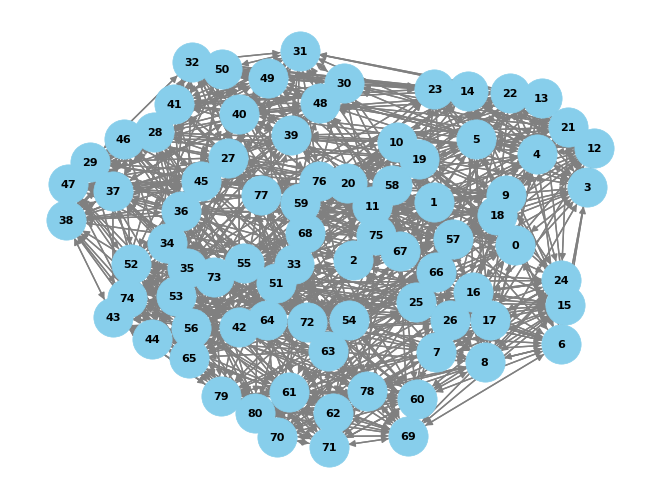

In [82]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes and edges to the graph
for node, neighbors in edges_dict.items():
    G.add_node(node)
    G.add_edges_from([(node, neighbor) for neighbor in neighbors])

# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='skyblue', node_size=800, font_size=8, edge_color='gray', linewidths=0.5)

# Show the plot
plt.show()

In [83]:
filled_sudokus = pd.read_csv('./filled_sudokus.csv')
filled_sudokus

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,8,8,3,2,9,5,4,1,7,4,...,1,2,5,7,9,1,3,4,4,8
1,1,6,9,7,5,4,8,3,2,3,...,4,4,9,7,6,2,5,1,8,3
2,7,1,2,6,5,4,8,3,9,8,...,2,5,8,6,2,4,9,3,1,7
3,2,7,4,5,9,3,6,8,7,8,...,4,4,9,7,2,1,8,3,5,2
4,6,5,2,7,3,4,8,9,1,3,...,9,7,4,6,8,8,9,3,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,8,9,5,2,4,3,5,7,6,...,2,8,6,4,3,9,2,7,1,5
49996,7,4,1,3,5,9,2,6,8,9,...,9,4,9,3,8,6,5,7,1,2
49997,2,5,7,4,6,3,9,1,8,1,...,9,8,9,6,3,7,2,1,5,4
49998,9,3,8,2,5,7,1,4,6,1,...,2,2,9,6,8,7,8,4,3,5


In [84]:
train_sudokus = pd.DataFrame({
    'partialsudokus': partial_sudokus.apply(lambda row: (''.join(map(str, row))), axis=1),
    'filledsudokus': filled_sudokus.apply(lambda row: (''.join(map(str, row))), axis=1)
})

train_sudokus

,partialsudokus,filledsudokus
0,0832354170018000590350008620700009000000700203...,8832954174218673597953418625721349868465791233...
1,1007540320002060070048390500070780000405903100...,1697548323582169472748396515314782967465923189...
2,3000508398000230409300782002798004000004970266...,7126548398659237419342782652798614533584871266...
3,0000930078030000290590824039003502036001007088...,2745936878637415297596824139783542616351297481...
4,6807300908986000070370002560003456020000080742...,6527348913986524374371982569713456823852619742...
...,...,...
49995,0896000576200008000408102060107098239020800000...,1895243576279351845438172964167598239724835613...
49996,7413090080050800402300000708000360276570481903...,7413592689657823412386149757895364276572488933...
49997,2004839101040080000800057034200030080008064979...,2574639181347986256892157438219573863758264919...
49998,9082000000024609706748000507000193800000025003...,9382571461524639786748912537256193844593825173...


In [85]:
train_sudokus.to_csv('./train_sudokus.csv')

In [86]:
test_sudokus = pd.read_csv('./test_sudokus.csv')
test_sudokus

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,4,0,2,7,0,0,8,6,3,7,...,0,7,3,6,0,2,7,5,0,0
1,0,7,0,8,0,1,0,2,0,0,...,0,0,0,7,0,0,7,0,0,0
2,0,0,0,7,0,0,4,6,5,0,...,7,5,0,0,4,0,0,3,1,2
3,4,5,8,0,0,9,6,0,7,0,...,6,0,6,0,0,0,0,4,0,0
4,0,0,7,0,5,0,0,0,9,6,...,8,8,0,9,3,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,1,0,5,0,3,0,0,...,0,0,4,2,5,0,0,0,0,3
9996,1,0,5,8,0,0,0,4,0,4,...,0,7,6,2,0,4,3,0,0,3
9997,0,0,0,0,2,7,8,0,0,0,...,3,8,0,5,1,3,0,4,0,7
9998,0,0,2,0,7,5,0,0,0,0,...,0,2,0,0,9,0,3,8,0,5


In [87]:
data = pd.read_csv('./train_sudokus.csv')
data

,Unnamed: 0,partialsudokus,filledsudokus
0,0,0832354170018000590350008620700009000000700203...,8832954174218673597953418625721349868465791233...
1,1,1007540320002060070048390500070780000405903100...,1697548323582169472748396515314782967465923189...
2,2,3000508398000230409300782002798004000004970266...,7126548398659237419342782652798614533584871266...
3,3,0000930078030000290590824039003502036001007088...,2745936878637415297596824139783542616351297481...
4,4,6807300908986000070370002560003456020000080742...,6527348913986524374371982569713456823852619742...
...,...,...,...
49995,49995,0896000576200008000408102060107098239020800000...,1895243576279351845438172964167598239724835613...
49996,49996,7413090080050800402300000708000360276570481903...,7413592689657823412386149757895364276572488933...
49997,49997,2004839101040080000800057034200030080008064979...,2574639181347986256892157438219573863758264919...
49998,49998,9082000000024609706748000507000193800000025003...,9382571461524639786748912537256193844593825173...


In [88]:
train_sudokus = pd.DataFrame(data.iloc[:, 1:3])
train_sudokus

,partialsudokus,filledsudokus
0,0832354170018000590350008620700009000000700203...,8832954174218673597953418625721349868465791233...
1,1007540320002060070048390500070780000405903100...,1697548323582169472748396515314782967465923189...
2,3000508398000230409300782002798004000004970266...,7126548398659237419342782652798614533584871266...
3,0000930078030000290590824039003502036001007088...,2745936878637415297596824139783542616351297481...
4,6807300908986000070370002560003456020000080742...,6527348913986524374371982569713456823852619742...
...,...,...
49995,0896000576200008000408102060107098239020800000...,1895243576279351845438172964167598239724835613...
49996,7413090080050800402300000708000360276570481903...,7413592689657823412386149757895364276572488933...
49997,2004839101040080000800057034200030080008064979...,2574639181347986256892157438219573863758264919...
49998,9082000000024609706748000507000193800000025003...,9382571461524639786748912537256193844593825173...


In [89]:
# Function to check length
def check_length(sudoku_str):
    return len(sudoku_str) == 81

# Applying the check_length function to each element in the specified columns
partial_lengths = data['partialsudokus'].apply(lambda x: check_length(x))
filled_lengths = data['filledsudokus'].apply(lambda x: check_length(x))

# Display the results
print("Rows with Incorrect Partial Sudokus Length:")
print(data[~partial_lengths])

print("\nRows with Incorrect Filled Sudokus Length:")
print(data[~filled_lengths])

Rows with Incorrect Partial Sudokus Length:
Empty DataFrame
Columns: [Unnamed: 0, partialsudokus, filledsudokus]
Index: []

Rows with Incorrect Filled Sudokus Length:
Empty DataFrame
Columns: [Unnamed: 0, partialsudokus, filledsudokus]
Index: []


In [90]:
def create_constraint_mask():
    constraint_mask = torch.zeros((81, 3, 81), dtype=torch.float)
    # row constraints
    for a in range(81):
        r = 9 * (a // 9)
        for b in range(9):
            constraint_mask[a, 0, r + b] = 1

    # column constraints
    for a in range(81):
        c = a % 9
        for b in range(9):
            constraint_mask[a, 1, c + 9 * b] = 1

    # box constraints
    for a in range(81):
        r = a // 9
        c = a % 9
        br = 3 * 9 * (r // 3)
        bc = 3 * (c // 3)
        for b in range(9):
            r = b % 3
            c = 9 * (b // 3)
            constraint_mask[a, 2, br + bc + r + c] = 1

    return constraint_mask

In [91]:
class SudokuDataset(Dataset):
    def __init__(self, dataframe, subset="train"):
        self.dataframe = dataframe
        self.subset = subset

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        puzzle = self.dataframe.iloc[idx, 1]
        solution = self.dataframe.iloc[idx, 2]
        #print(puzzle)
        puzzle = torch.tensor([int(p) for p in str(puzzle)], dtype=torch.float32).reshape(1, 9, 9) / 9 - 0.5
            # Subtracting 1 from each solution value to match PyTorch's 0-based indexing
            #solution = torch.tensor([max(0, int(s) - 1) for s in solution], dtype=torch.int64).reshape(-1)
        solution = torch.tensor([int(s) - 1 for s in str(solution)], dtype=torch.int64).reshape(81)
        return puzzle, solution

In [63]:
train_idx = int(len(data) * 0.75)
train_data = SudokuDataset(data.iloc[:train_idx])
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)

val_data = SudokuDataset(data.iloc[train_idx:])
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [49]:
import torch.nn as nn
import torch.nn.functional as F

class SudokuSolver(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(SudokuSolver, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=1)
        self.fc1 = nn.Linear(128 * 9 * 9, 81 * 9)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = x.view(-1, 9)  # Reshaped to match [batch_size * 81, 9]

        return x
model = SudokuSolver()
#model = SudokuSolver(adjacency_matrix_size=81)


In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class ResNetSudokuSolver(nn.Module):
    def __init__(self):
        super(ResNetSudokuSolver, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.residual_block1 = ResidualBlock(64, 64)
        self.residual_block2 = ResidualBlock(64, 64)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 81 * 9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(-1, 9)  # Reshaped to match [batch_size * 81, 9]
        return x

model = ResNetSudokuSolver()

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [66]:
import torch.optim.lr_scheduler as lr_scheduler

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def train_model(model, train_loader, val_loader, epochs, adjacency_matrix, plots):
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0
        # Training Phase
        for puzzles, solutions in train_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            optimizer.zero_grad()
            outputs = model(puzzles)
            # print('outputs :', outputs)
            #print('sols :', solutions.view(-1))
            loss = criterion(outputs, solutions.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            train_correct += calculate_accuracy(outputs, solutions.view(-1)) * solutions.size(0)
            total_train += solutions.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)
        train_accuracy = train_correct / total_train
        train_acc_list.append(train_accuracy)
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for puzzles, solutions in val_loader:
                puzzles, solutions = puzzles.to(device), solutions.to(device)
                outputs = model(puzzles)
                val_loss += criterion(outputs, solutions.view(-1)).item()
                
                val_correct += calculate_accuracy(outputs, solutions.view(-1)) * solutions.size(0)
                total_val += solutions.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        val_accuracy = val_correct / total_val
        val_acc_list.append(val_accuracy)
        
        #scheduler.step(avg_val_loss)

        print(f'Epoch {epoch + 1}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')
 
    if plots:
        plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_loss_list, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.plot(range(1, epochs + 1), train_acc_list, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

CNN Training

In [47]:
model = SudokuSolver()

Epoch 1: Train Loss: 1.9679, Train Accuracy: 0.2386, Validation Loss: 1.5278, Validation Accuracy: 0.4567
Epoch 2: Train Loss: 1.3532, Train Accuracy: 0.5205, Validation Loss: 1.0527, Validation Accuracy: 0.6487
Epoch 3: Train Loss: 1.0957, Train Accuracy: 0.6216, Validation Loss: 0.8992, Validation Accuracy: 0.6968
Epoch 4: Train Loss: 0.9856, Train Accuracy: 0.6578, Validation Loss: 0.8283, Validation Accuracy: 0.7148
Epoch 5: Train Loss: 0.9279, Train Accuracy: 0.6764, Validation Loss: 0.7971, Validation Accuracy: 0.7212
Epoch 6: Train Loss: 0.8903, Train Accuracy: 0.6889, Validation Loss: 0.7785, Validation Accuracy: 0.7248
Epoch 7: Train Loss: 0.8658, Train Accuracy: 0.6967, Validation Loss: 0.7686, Validation Accuracy: 0.7264
Epoch 8: Train Loss: 0.8467, Train Accuracy: 0.7031, Validation Loss: 0.7615, Validation Accuracy: 0.7274
Epoch 9: Train Loss: 0.8339, Train Accuracy: 0.7077, Validation Loss: 0.7570, Validation Accuracy: 0.7277


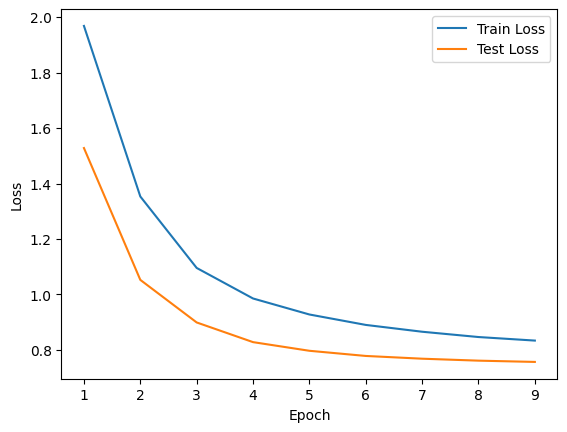

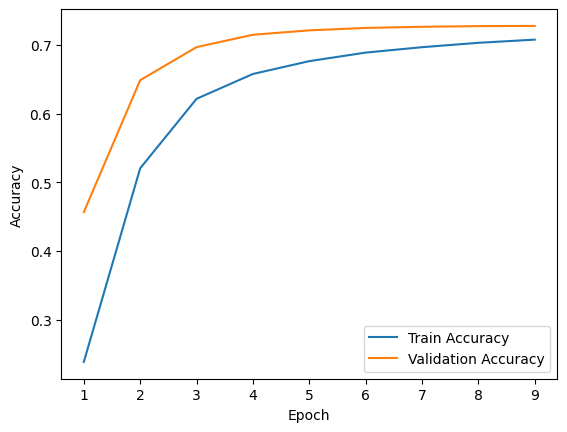

In [52]:
train_model(model, train_loader, val_loader, 9, adjacency_matrix, plots = True)

In [53]:
model

SudokuSolver(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=10368, out_features=729, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

After 9th epoch, for CNN, train accuracy overshoots validation accuracy and it starts overfitting
lr=0.001, batch size 32, 

ResNet Training

Epoch 1: Train Loss: 1.8858, Train Accuracy: 0.2483, Validation Loss: 1.9235, Validation Accuracy: 0.2312
Epoch 2: Train Loss: 1.8816, Train Accuracy: 0.2495, Validation Loss: 1.9220, Validation Accuracy: 0.2316
Epoch 3: Train Loss: 1.8782, Train Accuracy: 0.2506, Validation Loss: 1.9208, Validation Accuracy: 0.2323
Epoch 4: Train Loss: 1.8754, Train Accuracy: 0.2514, Validation Loss: 1.9188, Validation Accuracy: 0.2328
Epoch 5: Train Loss: 1.8725, Train Accuracy: 0.2524, Validation Loss: 1.9166, Validation Accuracy: 0.2337
Epoch 6: Train Loss: 1.8695, Train Accuracy: 0.2536, Validation Loss: 1.9140, Validation Accuracy: 0.2344
Epoch 7: Train Loss: 1.8666, Train Accuracy: 0.2546, Validation Loss: 1.9122, Validation Accuracy: 0.2352
Epoch 8: Train Loss: 1.8643, Train Accuracy: 0.2555, Validation Loss: 1.9123, Validation Accuracy: 0.2358
Epoch 9: Train Loss: 1.8624, Train Accuracy: 0.2563, Validation Loss: 1.9111, Validation Accuracy: 0.2361
Epoch 10: Train Loss: 1.8606, Train Accuracy: 

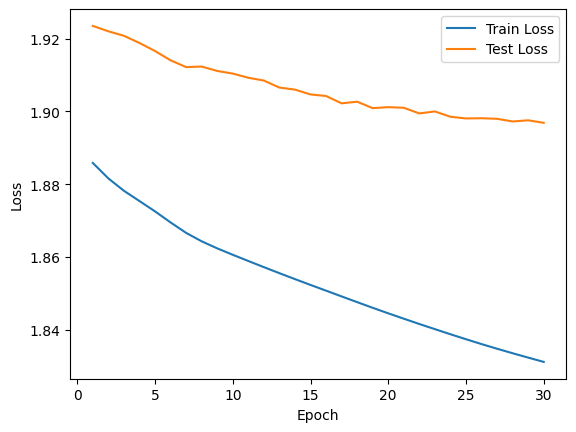

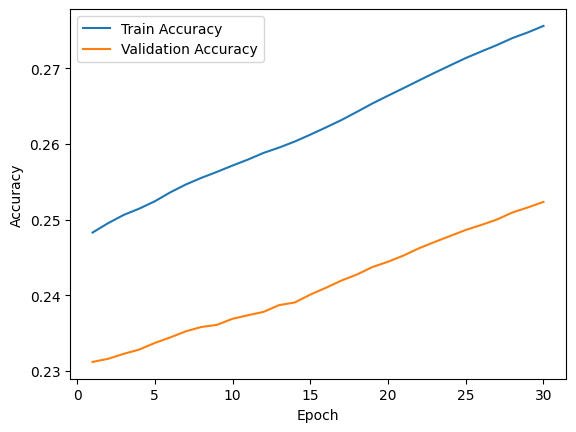

In [68]:
# model = ResNetSudokuSolver()
train_model(model, train_loader, val_loader, 30, adjacency_matrix, plots = True)

In [69]:
model

ResNetSudokuSolver(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (residual_block1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential()
  )
  (residual_block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [70]:
import pandas as pd
test=pd.read_csv('./test_sudokus.csv')
test_sudokus = pd.DataFrame({
    'partialsudokus': test.apply(lambda row: (''.join(map(str, row))), axis=1),
})

test_sudokus

,partialsudokus
0,4027008637644000250800000706070950007706000541...
1,0708010200207300001060970040400758800820080037...
2,0007004650804000306042437008070950230307046009...
3,4580096070000760027264783000157040000040800540...
4,0070500096038004059700008361080005032060350800...
...,...
9995,0001050300407062400009408607540943060802507040...
9996,1058000404001300056030809470006005345060030097...
9997,0000278000703000400487500367800000040524009783...
9998,0020750000394800001050020980047200803275009164...


In [71]:
def check_length(sudoku_str):
    return len(sudoku_str) == 81

partial_lengths = data['partialsudokus'].apply(lambda x: check_length(x))

print("Rows with Incorrect Partial Sudokus Length:")
print(data[~partial_lengths])


Rows with Incorrect Partial Sudokus Length:
Empty DataFrame
Columns: [Unnamed: 0, partialsudokus, filledsudokus]
Index: []


In [72]:
def preprocess_puzzle(puzzle_str):

    puzzle_tensor = torch.tensor([int(p) for p in puzzle_str], dtype=torch.float32).reshape(1, 1, 9, 9) / 9 - 0.5
    return puzzle_tensor.to(device)

def predict_test_set(model, test_df):
    model.eval()
    predictions = []

    for _, row in test_df.iterrows():
        #print(row)
        puzzle_str = row['partialsudokus']
        with torch.no_grad():
            puzzle_tensor = preprocess_puzzle(puzzle_str)
            output = model(puzzle_tensor)
            solution = output.argmax(dim=1).view(9, 9) + 1  # Convert predictions to 1-based indexing
            predictions.append(solution.cpu().numpy())

    return predictions
predicted_solutions = predict_test_set(model, test_sudokus)

In [73]:
indexes = []
labels= []
for i,j in enumerate(predicted_solutions):
    preds = j.reshape(9,9)
    for row in range(0,9):
        for col in range(0,9):
            index = str(i)+"_"+str(row)+str(col)
            indexes.append(index)
            labels.append(preds[row,col])

In [74]:
test_predictions =  {"id":indexes , "values":labels}
test_predictions = pd.DataFrame(test_predictions)
test_predictions

,id,values
0,0_00,3
1,0_01,8
2,0_02,4
3,0_03,9
4,0_04,8
...,...,...
809995,9999_84,5
809996,9999_85,1
809997,9999_86,3
809998,9999_87,9


In [75]:
test_predictions.to_csv("Submission_Task2_ResNet.csv", index=False)

### Summary
* Identified each digit in sudoku grid with task1approach1 model and concatenated them into strings for both inputs(train and test) and labels into a dataframe
* Normalised each digit in inputs(train and test) to be within range of -0.5 and 0.5
* Using CNN model to learn the sudoku rules from training data and predict thus for test data
* Converted the test data back into format suitable for submission file

| Task 2     | Model  | Accuracy(locally) | Accuracy(kaggle) |
|:--------:|:------:|:----------:|:----------:|
| Approach 1     | CNN  | 72% |  73%  |
| Approach 2     | ResNet  | 28% |   11%|

In [93]:
import torch
from torch_geometric.data import Data

# Example: Sudoku grid (0 represents empty cells)
sudoku_grid = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

# Flatten the Sudoku grid into a 1D tensor
sudoku_flat = [val for row in sudoku_grid for val in row]

# Create node features (initial state of each cell)
node_features = torch.tensor(sudoku_flat, dtype=torch.float).view(-1, 1)

# Create edge_index representing the relationships between cells
# This can be obtained from your edges dictionary
# Here, we use a simplified example
edges = [(0, 1), (0, 9), (0, 27)]  # Define edges based on your specific Sudoku grid

# Convert edges to PyTorch tensor
edge_index = torch.tensor(list(zip(*edges)), dtype=torch.long)

# Create the data object
data = Data(x=node_features, edge_index=edge_index)